# Model 3 - Evaluation 2

[Model 3](readme.md) ....

The model is defined in [model.py](model.py).

Here, we evaluate the model using observed variables from data set 2 times 1 through 4.


## Preliminaries


In [1]:
import platform
import os
import sys
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt
import model as m
from model import ModelConfig, ModelSpecification
import xarray as xr

pd.options.mode.copy_on_write = True

pytensor.config.mode = "NUMBA"
pytensor.config.print_active_device = True

az.style.use("arviz-whitegrid")

environment = {
    "platform": platform.platform(),
    "platform_version": platform.version(),
    "architecture": platform.architecture(),
    "processor": platform.processor(),
    "cpu_count": os.cpu_count(),
    "python": sys.version,
    "pymc": pm.__version__,
    "pytensor": pytensor.__version__,
    "numpy": np.__version__,
    "arviz": az.__version__,
}

print("Environment:")
for key, value in environment.items():
    print(f"  {key}: {value}")

Environment:
  platform: macOS-26.0-arm64-arm-64bit-Mach-O
  platform_version: Darwin Kernel Version 25.0.0: Mon Aug 25 21:16:39 PDT 2025; root:xnu-12377.1.9~3/RELEASE_ARM64_T6031
  architecture: ('64bit', 'Mach-O')
  processor: arm
  cpu_count: 16
  python: 3.13.7 (v3.13.7:bcee1c32211, Aug 14 2025, 19:10:51) [Clang 16.0.0 (clang-1600.0.26.6)]
  pymc: 5.25.1
  pytensor: 2.31.7
  numpy: 2.3.3
  arviz: 0.22.0


### Load data


In [2]:
df = pd.read_csv(
    "../../../../../data/reading-language-memory/rlm-data-5.csv"
).convert_dtypes()
df = df[df["readgrp"] == 2]

## Evaluate model


### Build model


In [3]:
spec = ModelSpecification(
    age=df["age1"].to_numpy(na_value=np.nan),
    gender=df["sex"].to_numpy(na_value=np.nan),    
    rv=df[
        ["bpvs1", "bpvs2", "bpvs3", "bpvs4"]
    ].to_numpy(na_value=np.nan),
    sp=df[
        ["basspel1", "basspel2", "basspel3", "basspel4"]
    ].to_numpy(na_value=np.nan),
    wr=df[
        ["basread1", "basread2", "basread3", "basread4"]
    ].to_numpy(na_value=np.nan),
)

model = m.build_model(spec)

### Model graph


In [4]:
# pm.model_to_graphviz(model)

### Run simulation


In [5]:
CHAINS = 4
CORES = CHAINS
RANDOM_SEED = 202509
rng = np.random.default_rng(RANDOM_SEED)

posterior_keep = [
    "B",
    "B_autoregressive",
    "B_crosslag",
    "B_half_life",
    "mu",
    "beta_age",
    "beta_person",
    "rho",
    "alpha_sd",
    "alpha_corr",
    "eta_sd",
    "delta",
    "p_bar",
    "items_per_logit",
]

with model:
    idata = pm.sample(
        draws=8000,
        tune=4000,
        chains=CHAINS,
        cores=CORES,
        target_accept=0.95,
        var_names=posterior_keep,
        idata_kwargs={"log_likelihood": True},
        return_inferencedata=True,
        init="jitter+adapt_diag",
        nuts_sampler="numpyro",
        chain_method="vectorized",
        # compile_kwargs=dict(mode="NUMBA"),
        random_seed=RANDOM_SEED,
    )

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

/Users/frankbuckley/dev/dseinternational/development-models/.venv/lib/python3.13/site-packages/jax/_src/interpreters/mlir.py:1316: UserWarning: Some donated buffers were not usable: float64[4,8000,6], float64[4,8000,42,3], float64[4,8000,42,3,3], float64[4,8000,6], float64[4,8000,42,3], float64[4,8000], float64[4,8000], float64[4,8000,42,4], float64[4,8000].
See an explanation at https://docs.jax.dev/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


## Diagnostics


In [6]:
az.bfmi(idata)

array([0.88298447, 0.85372687, 0.86711998, 0.84814756])

<Axes: >

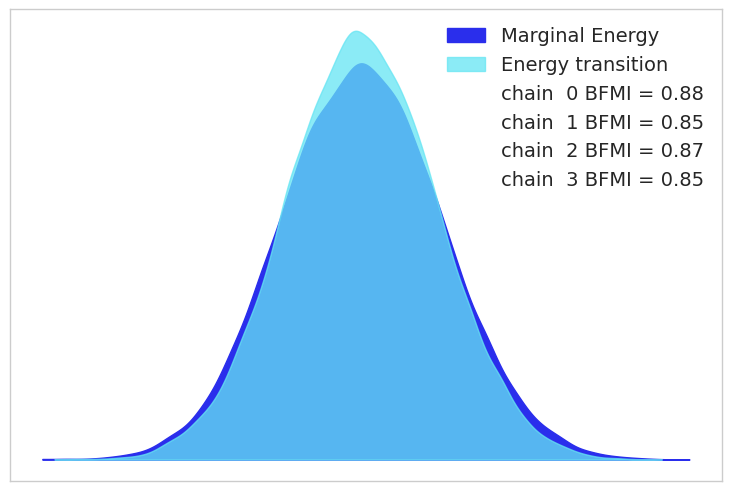

In [7]:
az.plot_energy(idata)

In [8]:
from pytensor import config

if config.mode.upper() == "NUMBA":
    config.mode = "FAST_COMPILE"

with model:
    # Prior predictive (force non-Numba mode)
    idata_pp = pm.sample_prior_predictive(
        samples=1000,
        var_names=[
            "mu",
            "B",
            "rho",
            "kappa",
            "alpha_sd",
            "alpha_corr",
            "eta_sd",
            "delta",
            "y",
        ],
        compile_kwargs={
            "mode": "FAST_COMPILE"
        }
    )
    idata.extend(idata_pp)

/var/folders/xy/9cdy15js451fxxnb4jpgv4zh0000gn/T/ipykernel_18691/1443674258.py:8: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata_pp = pm.sample_prior_predictive(
Sampling: [alpha_scale, alpha_z, beta_age, beta_person, day_raw, delta, delta_sd, eta_sd, init_scale, kappa_uncon, mu0, mu_step_sd, mu_steps, nu_mu_minus2, raw_B, state_shock, x1_z, y]


In [9]:

# 1) Get mu from the *prior* group (not prior_predictive)
mu = idata_pp.prior["mu"]                   # dims: ("chain","draw","construct","time")

# 2) Collapse chains -> one sample axis
mu_s = mu.stack(sample=("chain","draw"))    # dims: ("sample","construct","time")

# 3) Convert to probabilities
p = 1 / (1 + np.exp(-mu_s))                 # same dims

# 4) Quantiles over samples -> dims ("quantile","construct","time")
q = p.quantile(q=[0.05, 0.50, 0.95], dim="sample")

# 5a) Stay in xarray (recommended)
print(q)

# 5b) Or make a tidy pandas table with MultiIndex rows and quantiles as columns
df_p = (
    q.to_dataframe(name="p")                # index: quantile, construct, time
      .reset_index()
      .pivot_table(index=["construct","time"], columns="quantile", values="p")
      .rename(columns={0.05:"q05", 0.50:"q50", 0.95:"q95"})
      .sort_index()
)
df_p


<xarray.DataArray 'mu' (quantile: 3, construct: 3, time: 4)> Size: 288B
array([[[0.18141606, 0.16233113, 0.15003635, 0.13438572],
        [0.03605347, 0.03268123, 0.02894289, 0.02717089],
        [0.07989394, 0.07078118, 0.06392819, 0.05408111]],

       [[0.32350224, 0.32395565, 0.32901067, 0.32579371],
        [0.08180074, 0.0835625 , 0.08121004, 0.08070654],
        [0.16257357, 0.1655159 , 0.16303723, 0.16534354]],

       [[0.51565028, 0.5717314 , 0.5841058 , 0.62081756],
        [0.17239434, 0.19812   , 0.22356363, 0.23208849],
        [0.30090071, 0.34351292, 0.37398726, 0.41768871]]])
Coordinates:
  * construct  (construct) <U11 132B 'Vocab' 'Spelling' 'WordReading'
  * time       (time) int64 32B 1 2 3 4
  * quantile   (quantile) float64 24B 0.05 0.5 0.95


quantile               q05       q50       q95
construct   time                              
Spelling    1     0.036053  0.081801  0.172394
            2     0.032681  0.083563  0.198120
            3     0.028943  0.081210  0.223564
            4     0.027171  0.080707  0.232088
Vocab       1     0.181416  0.323502  0.515650
            2     0.162331  0.323956  0.571731
            3     0.150036  0.329011  0.584106
            4     0.134386  0.325794  0.620818
WordReading 1     0.079894  0.162574  0.300901
            2     0.070781  0.165516  0.343513
            3     0.063928  0.163037  0.373987
            4     0.054081  0.165344  0.417689

## Summaries


In [10]:
vars_to_report = [
    "B",
    "B_autoregressive",
    "B_crosslag",
    "B_half_life",
    "beta_age",
    "beta_person",
    "alpha_sd",
    "alpha_corr",
    "eta_sd",
    "mu",
    "p_bar",
    "items_per_logit",
    "delta",
]

summary = az.summary(idata, var_names=vars_to_report, hdi_prob=0.95)
summary.to_csv("summary2.csv")
summary

/Users/frankbuckley/dev/dseinternational/development-models/.venv/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/frankbuckley/dev/dseinternational/development-models/.venv/lib/python3.13/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/Users/frankbuckley/dev/dseinternational/development-models/.venv/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/frankbuckley/dev/dseinternational/development-models/.venv/lib/python3.13/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/Users/frankbuckley/dev/dseint

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"B[Vocab, Vocab]",0.123,0.186,-0.234,0.486,0.001,0.001,49586.0,26037.0,1.0
"B[Vocab, Spelling]",0.000,0.133,-0.246,0.274,0.001,0.001,40966.0,25874.0,1.0
"B[Vocab, WordReading]",-0.017,0.104,-0.219,0.189,0.001,0.001,26045.0,23458.0,1.0
"B[Spelling, Vocab]",0.014,0.143,-0.262,0.294,0.001,0.001,58606.0,23578.0,1.0
"B[Spelling, Spelling]",0.195,0.162,-0.124,0.502,0.001,0.001,24300.0,24498.0,1.0
...,...,...,...,...,...,...,...,...,...
"items_per_logit[WordReading, 3]",24.102,0.637,22.838,25.293,0.004,0.003,32480.0,26252.0,1.0
"items_per_logit[WordReading, 4]",19.102,1.037,17.022,21.079,0.006,0.005,33075.0,22154.0,1.0
delta[Vocab],0.028,0.028,0.000,0.085,0.000,0.000,13631.0,14680.0,1.0
delta[Spelling],0.031,0.033,0.000,0.098,0.000,0.000,11539.0,13613.0,1.0
